This script fits the non-first-term model using exclusively in-person observations vs. the model using exclusively online observations.

In [1]:
import pickle
import pandas as pd
import numpy as np
from collections import Counter
import sklearn
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import precision_recall_curve, roc_auc_score, confusion_matrix, precision_score, recall_score
from sklearn.model_selection import KFold, StratifiedKFold
from scipy.stats.mstats import gmean
import seaborn as sns
import matplotlib.pyplot as plt

results_dir = "~\\Box Sync\\Clickstream\\evaluation_results\\full\\"

In [2]:
sn_dict = {"Blue Ridge": "BRCC",
           "Central Virginia": "CVCC",
           "Dabney S. Lancaster": "DSLCC",
           "Danville": "DCC",
           "Eastern Shore": "ESCC",
           "Germanna": "GCC",
           'J. Sargeant Reynolds': "JSRCC",
           'John Tyler': "JTCC",
           "Lord Fairfax": "LFCC",
           "Mountain Empire": "MECC",
           "New River": "NRCC",
           "Northern Virginia": "NVCC",
           "Patrick Henry": "PHCC",
           "Paul D. Camp": "PDCCC",
           "Piedmont Virginia": "PVCC",
           "Rappahannock": "RCC",
           "Southside Virginia": "SSVCC",
           "Southwest Virginia": "SWVCC",
           "Thomas Nelson": "TNCC",
           "Tidewater": "TCC",
           "Virginia Highlands": "VHCC",
           "Virginia Western": "VWCC",
           "Wytheville": "WCC"}

In [3]:
df0 = pd.read_csv("~\\Box Sync\\Clickstream\\data\\full\\LMS_data_final_full_new.csv")
df1 = pd.read_csv("~\\Box Sync\\Clickstream\\data\\full\\course_specific_predictors_new.csv")
df2 = pd.read_csv("~\\Box Sync\\Clickstream\\data\\full\\term_specific_predictors_new.csv")
for v in [int(e) for e in np.unique(df2.cip) if e != 0]:
    df2.loc[:,'cip_'+str(v)] = (df2.cip == v).astype(int)
for v in [int(e) for e in np.unique(df2.degree_level) if e != 4]:
    df2.loc[:,'degree_level_'+str(v)] = (df2.degree_level == v).astype(int)
df2 = df2.drop(['cip', 'degree_level'], axis=1)
df3 = pd.read_csv("~\\Box Sync\\Clickstream\\data\\full\\cluster_specific_predictors.csv")
df4 = pd.read_stata("~\\Box Sync\\Clickstream\\data\\full\\instructor_related_predictors.dta")
df5 = df0.loc[:,['vccsid','strm','college','course','section']].copy()
df5.loc[:,'college_new'] = df5.college.apply(lambda x: sn_dict[x])
for sn in [e for e in sn_dict.values() if e != "BRCC"]:
    df5.loc[:,'college_'+sn] = (df5.college_new == sn).astype(int)
df5 = df5.drop(['college_new'], axis=1)
df = df0.merge(df1, how='inner', on=['vccsid','strm','college','course','section'])\
.merge(df2, how='inner', on=['vccsid','strm'])\
.merge(df3, how='inner', on=['vccsid','strm','college','course','section'])\
.merge(df4, how='inner', on=['vccsid','strm','college','course','section'])\
.merge(df5, how='inner', on=['vccsid','strm','college','course','section'])
predictors = [e for e in list(df.columns)[5:] if e != "grade"]
len(predictors)

329

In [4]:
inperson_ind = pd.read_stata("~\\Box Sync\\Clickstream\\data\\full\\updated_online_ind.dta")

In [9]:
inperson_1 = inperson_ind[inperson_ind.inperson_ind == 1].drop(['online_ind', 'inperson_ind'], axis=1)
inperson_0 = inperson_ind[inperson_ind.online_ind == 1].drop(['online_ind', 'inperson_ind'], axis=1)

In [10]:
df_inperson = df.merge(inperson_1, on=['vccsid', 'college', 'strm', 'course', 'section'], how='inner')
df_online = df.merge(inperson_0, on=['vccsid', 'college', 'strm', 'course', 'section'], how='inner')

In [13]:
df_online.shape, df_inperson.shape

((730410, 335), (233675, 335))

In [15]:
assert pd.isnull(df_online).any().any() == False
assert pd.isnull(df_inperson).any().any() == False

In [16]:
train_df_online = df_online[df_online.strm != 2212]
test_df_online = df_online[df_online.strm == 2212]
original_test_grade = np.array(test_df_online.grade)
train_df_online.loc[:,'grade'] = train_df_online.apply(lambda x: 1 if x.loc['grade'] in {'A','B','C'} else 0, axis=1)
test_df_online.loc[:,'grade'] = test_df_online.apply(lambda x: 1 if x.loc['grade'] in {'A','B','C'} else 0, axis=1)
print(train_df_online.shape,test_df_online.shape)

C:\Users\ys8mz\AppData\Local\Continuum\Anaconda3\lib\site-packages\pandas\core\indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


(475104, 335) (255306, 335)


In [17]:
train_df_inperson = df_inperson[df_inperson.strm != 2212]
test_df_inperson = df_inperson[df_inperson.strm == 2212]
original_test_grade = np.array(test_df_inperson.grade)
train_df_inperson.loc[:,'grade'] = train_df_inperson.apply(lambda x: 1 if x.loc['grade'] in {'A','B','C'} else 0, axis=1)
test_df_inperson.loc[:,'grade'] = test_df_inperson.apply(lambda x: 1 if x.loc['grade'] in {'A','B','C'} else 0, axis=1)
print(train_df_inperson.shape,test_df_inperson.shape)

C:\Users\ys8mz\AppData\Local\Continuum\Anaconda3\lib\site-packages\pandas\core\indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


(218389, 335) (15286, 335)


In [19]:
def create_cv_folds(train, n_fold = 5):
    folds = []
    k_fold = StratifiedKFold(n_splits = n_fold, random_state = 12345, shuffle=True)
    for train_indices, test_indices in k_fold.split(train, train.grade):
        train_part = train.iloc[train_indices,:]
        test_part = train.iloc[test_indices,:]
        X_1 = train_part.loc[:,predictors]
        y_1 = train_part.grade
        X_2 = test_part.loc[:,predictors]
        y_2 = test_part.grade
        folds.append([(X_1.copy(),y_1.copy()),(X_2.copy(),y_2.copy())])
    return folds

In [20]:
five_folds_online = create_cv_folds(train_df_online)
five_folds_inperson = create_cv_folds(train_df_inperson)

In [21]:
def cross_validation_RF(rf_model, folds):
    auc_by_fold = []
    for f in folds:
        X_1 = f[0][0]
        y_1 = f[0][1]
        X_2 = f[1][0]
        y_2 = f[1][1]
        rf_model.fit(X_1,y_1)
        y_2_pred = rf_model.predict_proba(X_2)[:,1]
        auc_by_fold.append(roc_auc_score(y_2,y_2_pred))
    return round(np.mean(auc_by_fold),4)  

In [22]:
def calc_cw(y):
    # Calculate the weight of each letter grade to be used in the modeling fitting procedure: the weight is inversely proportional to the square root of the frequency of the letter grade in the training sample
    cw = Counter(y)
    class_weight = {k:np.sqrt(cw.most_common()[0][-1]/v, dtype=np.float32) for k,v in cw.items()}
    return class_weight # The output is a dictionary mapping letter grade to the corresponding weight

In [23]:
### Using grid search to find the optimal maximum tree depth
auc_by_d=[]
for d in range(20,31):
    rf = RandomForestClassifier(n_estimators=200, criterion="entropy", 
                                max_depth=d,
                                random_state=0, n_jobs=20, max_features="auto",
                                class_weight = calc_cw(train_df_online.grade))
    auc = cross_validation_RF(rf, five_folds_online)
    auc_by_d.append(auc)
    print("Max_depth =", d)
    print("Mean CV AUC:", auc)
    print("")
plt.plot(range(20,31),auc_by_d)
plt.xlabel("Maximum Depth")
plt.ylabel("AUC")
plt.show()

Max_depth = 20
Mean CV AUC: 0.8731

Max_depth = 21
Mean CV AUC: 0.8746

Max_depth = 22
Mean CV AUC: 0.876

Max_depth = 23
Mean CV AUC: 0.8772

Max_depth = 24
Mean CV AUC: 0.8782

Max_depth = 25
Mean CV AUC: 0.8791



KeyboardInterrupt: 

In [24]:
### Using grid search to find the optimal number of estimators (trees)
auc_by_n = []
for n in range(100,320,20):
    rf = RandomForestClassifier(n_estimators=n, criterion="entropy", 
                                max_depth=24,
                                random_state=0, n_jobs=-1, max_features="auto",
                                class_weight = calc_cw(train_df_online.grade))
    auc = cross_validation_RF(rf, five_folds_online)
    auc_by_n.append(auc)
    print("Number of Trees =", n)
    print("Mean CV AUC:", auc)
    print("")
plt.plot(range(100,320,20), auc_by_n)
plt.xlabel("Number of Trees")
plt.ylabel("AUC")
plt.show()

Number of Trees = 100
Mean CV AUC: 0.8763

Number of Trees = 120
Mean CV AUC: 0.877

Number of Trees = 140
Mean CV AUC: 0.8774

Number of Trees = 160
Mean CV AUC: 0.8778

Number of Trees = 180
Mean CV AUC: 0.878

Number of Trees = 200
Mean CV AUC: 0.8782

Number of Trees = 220
Mean CV AUC: 0.8783

Number of Trees = 240
Mean CV AUC: 0.8784

Number of Trees = 260
Mean CV AUC: 0.8786

Number of Trees = 280
Mean CV AUC: 0.8786



KeyboardInterrupt: 

Max_features = 8
Mean CV AUC: 0.8691

Max_features = 9
Mean CV AUC: 0.8711

Max_features = 10
Mean CV AUC: 0.8726

Max_features = 11
Mean CV AUC: 0.8739

Max_features = 12
Mean CV AUC: 0.875

Max_features = 13
Mean CV AUC: 0.8757

Max_features = 14
Mean CV AUC: 0.8764

Max_features = 15
Mean CV AUC: 0.8772

Max_features = 16
Mean CV AUC: 0.8777

Max_features = 17
Mean CV AUC: 0.8781

Max_features = 18
Mean CV AUC: 0.8786

Max_features = 19
Mean CV AUC: 0.8788

Max_features = 20
Mean CV AUC: 0.8792

Max_features = 21
Mean CV AUC: 0.8794

Max_features = 22
Mean CV AUC: 0.8797

Max_features = 23
Mean CV AUC: 0.8799

Max_features = 24
Mean CV AUC: 0.88

Max_features = 25
Mean CV AUC: 0.88

Max_features = 26
Mean CV AUC: 0.8801

Max_features = 27
Mean CV AUC: 0.8804

Max_features = 28
Mean CV AUC: 0.8805

Max_features = 29
Mean CV AUC: 0.8806

Max_features = 30
Mean CV AUC: 0.8808

Max_features = 31
Mean CV AUC: 0.881

Max_features = 32
Mean CV AUC: 0.8809

Max_features = 33
Mean CV AUC: 0.

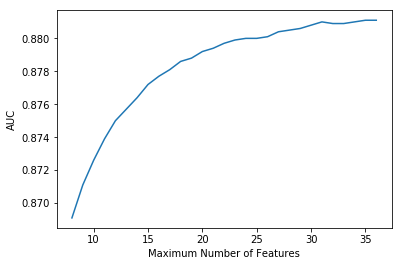

In [25]:
### Using grid search to find the optimal maximum number of features (trees)
auc_by_nf = []
max_nf = int(np.floor(2*np.sqrt(len(predictors))))
for nf in range(8,max_nf+1):
    rf = RandomForestClassifier(n_estimators=260, criterion="entropy", 
                                max_depth=24,
                                random_state=0, n_jobs=-1, max_features=nf,
                                class_weight = calc_cw(train_df_online.grade))
    auc = cross_validation_RF(rf, five_folds_online)
    auc_by_nf.append(auc)
    print("Max_features =", nf)
    print("Mean CV AUC:", auc)
    print("")
plt.plot(range(8,max_nf+1), auc_by_nf)
plt.xlabel("Maximum Number of Features")
plt.ylabel("AUC")
plt.show()

In [26]:
rf_online = RandomForestClassifier(n_estimators=260, criterion="entropy",
                                   max_depth=24,
                                   random_state=0, n_jobs=-1, max_features=16,
                                   class_weight = calc_cw(train_df_online.grade))
rf_online.fit(train_df_online.loc[:,predictors], train_df_online.grade)

RandomForestClassifier(bootstrap=True, class_weight={0: 1.8510445, 1: 1.0},
            criterion='entropy', max_depth=24, max_features=16,
            max_leaf_nodes=None, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=260, n_jobs=-1, oob_score=False, random_state=0,
            verbose=0, warm_start=False)

In [27]:
print("Random Forest Online:")
print("AUC = {}".format(round(roc_auc_score(test_df_online.grade, rf_online.predict_proba(test_df_online.loc[:,predictors])[:,1]),4)))
y_test_pred_rf_online = rf_online.predict_proba(test_df_online.loc[:,predictors])[:,1]

Random Forest Online:
AUC = 0.8684


In [29]:
### Using grid search to find the optimal maximum tree depth
auc_by_d=[]
for d in range(22,31):
    rf = RandomForestClassifier(n_estimators=200, criterion="entropy", 
                                max_depth=d,
                                random_state=0, n_jobs=20, max_features="auto",
                                class_weight = calc_cw(train_df_inperson.grade))
    auc = cross_validation_RF(rf, five_folds_inperson)
    auc_by_d.append(auc)
    print("Max_depth =", d)
    print("Mean CV AUC:", auc)
    print("")
plt.plot(range(22,31),auc_by_d)
plt.xlabel("Maximum Depth")
plt.ylabel("AUC")
plt.show()

Max_depth = 22
Mean CV AUC: 0.8676

Max_depth = 23
Mean CV AUC: 0.869

Max_depth = 24
Mean CV AUC: 0.8706

Max_depth = 25
Mean CV AUC: 0.8718

Max_depth = 26
Mean CV AUC: 0.8728

Max_depth = 27
Mean CV AUC: 0.8737



KeyboardInterrupt: 

Number of Trees = 100
Mean CV AUC: 0.8705

Number of Trees = 120
Mean CV AUC: 0.8713

Number of Trees = 140
Mean CV AUC: 0.8718

Number of Trees = 160
Mean CV AUC: 0.8722

Number of Trees = 180
Mean CV AUC: 0.8726

Number of Trees = 200
Mean CV AUC: 0.8728

Number of Trees = 220
Mean CV AUC: 0.8729

Number of Trees = 240
Mean CV AUC: 0.873

Number of Trees = 260
Mean CV AUC: 0.8732

Number of Trees = 280
Mean CV AUC: 0.8733

Number of Trees = 300
Mean CV AUC: 0.8734



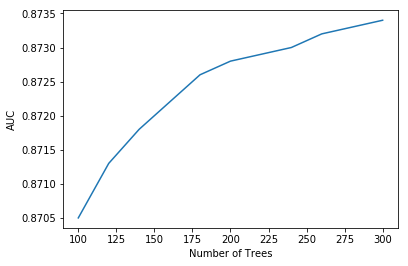

In [30]:
### Using grid search to find the optimal number of estimators (trees)
auc_by_n = []
for n in range(100,320,20):
    rf = RandomForestClassifier(n_estimators=n, criterion="entropy", 
                                max_depth=26,
                                random_state=0, n_jobs=-1, max_features="auto",
                                class_weight = calc_cw(train_df_inperson.grade))
    auc = cross_validation_RF(rf, five_folds_inperson)
    auc_by_n.append(auc)
    print("Number of Trees =", n)
    print("Mean CV AUC:", auc)
    print("")
plt.plot(range(100,320,20), auc_by_n)
plt.xlabel("Number of Trees")
plt.ylabel("AUC")
plt.show()

In [31]:
### Using grid search to find the optimal maximum number of features (trees)
auc_by_nf = []
max_nf = int(np.floor(2*np.sqrt(len(predictors))))
for nf in range(5,max_nf+1):
    rf = RandomForestClassifier(n_estimators=300, criterion="entropy", 
                                max_depth=26,
                                random_state=0, n_jobs=-1, max_features=nf,
                                class_weight = calc_cw(train_df_inperson.grade))
    auc = cross_validation_RF(rf, five_folds_inperson)
    auc_by_nf.append(auc)
    print("Max_features =", nf)
    print("Mean CV AUC:", auc)
    print("")
plt.plot(range(5,max_nf+1), auc_by_nf)
plt.xlabel("Maximum Number of Features")
plt.ylabel("AUC")
plt.show()

Max_features = 5
Mean CV AUC: 0.8538

Max_features = 6
Mean CV AUC: 0.8573

Max_features = 7
Mean CV AUC: 0.8598

Max_features = 8
Mean CV AUC: 0.8628

Max_features = 9
Mean CV AUC: 0.8646

Max_features = 10
Mean CV AUC: 0.8664

Max_features = 11
Mean CV AUC: 0.8681

Max_features = 12
Mean CV AUC: 0.8695

Max_features = 13
Mean CV AUC: 0.8704

Max_features = 14
Mean CV AUC: 0.8713

Max_features = 15
Mean CV AUC: 0.8719

Max_features = 16
Mean CV AUC: 0.8726

Max_features = 17
Mean CV AUC: 0.8732

Max_features = 18
Mean CV AUC: 0.8734

Max_features = 19
Mean CV AUC: 0.874

Max_features = 20
Mean CV AUC: 0.8742

Max_features = 21
Mean CV AUC: 0.8748

Max_features = 22
Mean CV AUC: 0.8748

Max_features = 23
Mean CV AUC: 0.8751

Max_features = 24
Mean CV AUC: 0.8755

Max_features = 25
Mean CV AUC: 0.8755

Max_features = 26
Mean CV AUC: 0.8759

Max_features = 27
Mean CV AUC: 0.8762

Max_features = 28
Mean CV AUC: 0.8762

Max_features = 29
Mean CV AUC: 0.8762

Max_features = 30
Mean CV AUC: 

KeyboardInterrupt: 

In [32]:
rf_inperson = RandomForestClassifier(n_estimators=300, criterion="entropy",
                                   max_depth=26,
                                   random_state=0, n_jobs=-1, max_features=17,
                                   class_weight = calc_cw(train_df_inperson.grade))
rf_inperson.fit(train_df_inperson.loc[:,predictors], train_df_inperson.grade)

RandomForestClassifier(bootstrap=True, class_weight={0: 2.0218618, 1: 1.0},
            criterion='entropy', max_depth=26, max_features=17,
            max_leaf_nodes=None, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=300, n_jobs=-1, oob_score=False, random_state=0,
            verbose=0, warm_start=False)

In [33]:
print("Random Forest In-Person:")
print("AUC = {}".format(round(roc_auc_score(test_df_inperson.grade, rf_inperson.predict_proba(test_df_inperson.loc[:,predictors])[:,1]),4)))
y_test_pred_rf_inperson = rf_inperson.predict_proba(test_df_inperson.loc[:,predictors])[:,1]

Random Forest In-Person:
AUC = 0.8652


#### Feature importances

In [35]:
cw_df = pd.read_csv(results_dir + "predictor_crosswalk.csv").iloc[:,[0,1,3,4]]

In [7]:
cw_dict = \
{'pct_withdrawn': '% prior attempted credits "Withdrawn"',
 'crnt_enrl_intensity': '# credits attempted in the target term',
 'tot_click_cnt_qrt1': 'Total # clicks in the 1st quarter',
 'cum_gpa': 'Cumulative GPA',
 'assign_sub_cnt_qtr1': '# assignment submissions in the 1st quarter',
 'tot_time_qrt1': 'Total minutes spent in 1st quarter',
 'term_gpa_1': 'Term GPA of the last term prior to the target term',
 'tot_click_cnt_qrt1c': 'Total # clicks in the 1st quarter, averaged across concurrent courses',
 'avg_g': 'Average historical grade in the target course',
 'past_avg_grade': 'Average grade assigned by the instructor in the target course',
 'tot_time_qrt1c':'Total minutes spend in 1st quarter, averaged across concurrent courses', 
 'overall_prop_comp': '% prior attempted credits completed',
 'term_gpa_2': 'Term GPA of second-to-last term prior to the target term', 
 'irreg_session_len_qrt1': 'Stddev of session lengths in 1st quarter', 
 'avg_session_len_qrt1': 'Average session length in 1st quarter', 
 'avg_g_concurrent': 'Average historical grade in the concurrent courses',
 'avg_session_len_qrt1c': 'Average session length  in 1st quarter, averaged across concurrent courses',
 'irreg_session_len_qrt1c': 'Stddev of session lengths in 1st quarter, averaged across concurrent courses',
 'disc_reply_cnt_qtr1': '# discussion forum replies in 1st quarter',
 'section_size': 'Enrollment in target course section',
 'assign_sub_cnt_qtr1': 'Average # assignment submissions in 1st quarter, averaged across concurrent courses',
 'gpa_trend': 'Slope of term-level GPA in prior terms',
 'prop_comp_sd': 'Stddev of term-level credit completion rate',
 'age': 'Age at time of target course enrollment',
 'disc_post_cnt_qtr1': '# original discussion forum posts created in 1st quarter',
 'avg_depth_post_qtr1': 'Average position of posts in forum thread (original post = 1) in 1st quarter', 
 'on_time_assign_share_qtr1': '% on-time assignment submissions in the 1st quarter', 
 'cum_cred_earn': 'Total credits accumulated prior to target term',
 'avg_word_tot_qtr1': 'Average # words per discussion forum thread in 1st quarter',
 'summer_ind': 'Target course is in a Summer term',
 'lvl2_share': 'Target course is 200-level',
 'assign_sub_cnt_qtr1c': 'Average # assignment submissions in 1st quarter, averaged across concurrent courses',
 'on_time_assign_share_qtr1c': '% on-time assignment submissions in 1st quarter, averaged across concurrent courses',
 'online_share': '% attempted credits during target term that are online',
 'eve_share': '% attempted credits during target term that are evening',
 'degree_level_1': 'Enrolled in a transfer-oriented associate degree program',
 'dev': 'Enrolled in any development courses in the target term',
 'full_time': 'Instructor works full-time at VCCS',
 'has_on_time_assign_share_qtr1': 'On-time assignment submissions in 1st quarter data is available',
 'tenure': 'Instructor has been teaching at VCCS for 6+ years',
 'enrl_intensity_trend': "Slope of credits attempted in prior terms",
 'prior_tot_act_day_cnt': 'Total # days with any activity in full term, averaged across prior courses',
 'prior_tot_click_cnt': 'Total # clicks in thefull term, averaged across prior courses'}
cw_df_original = pd.DataFrame.from_dict(cw_dict, orient='index').reset_index()
cw_df_original.columns = ['predictor', 'predictor_meaning']

In [ ]:
early_lms = [e for e in predictors if (e.endswith("_qtr1") or e.endswith("_qrt1")) and (e != "has_concurrent_qtr1") and (e.startswith("prior_") == False)]
concurrent_lms = [e for e in predictors if e.endswith("_qtr1c") or e.endswith("_qrt1c") or e == 'has_concurrent_qtr1']
historical_early_lms = [e for e in predictors if e.startswith("prior") and (e.endswith("_qrt1") or e.endswith("_qtr1"))]
historical_full_lms = [e for e in predictors if e.startswith("prior") and e.endswith("_qrt1") == False and e.endswith("_qtr1") == False]
all_lms = early_lms + concurrent_lms + historical_early_lms + historical_full_lms
# assign_lms = [e for e in all_lms if "assign" in e]
# disc_lms = [e for e in all_lms if "disc" in e or "word" in e or "post" in e]
# click_lms = [e for e in all_lms if e not in assign_lms + disc_lms]
all_admin = [e for e in predictors if e not in set(all_lms)]

In [10]:
fi_df_online = pd.DataFrame({"feature_importance": rf_online.feature_importances_, "predictor": predictors})\
.loc[:,['predictor', 'feature_importance']].sort_values(['feature_importance'], ascending=False)
fi_df_online.loc[:,'feature_ranking'] = np.arange(1, fi_df_online.shape[0] + 1) / fi_df_online.shape[0]

In [38]:
fi_df_online_top30 = fi_df_online.iloc[:30,:]
fi_df_online_top30.loc[:,'feature_ranking'] = np.arange(1,31)
fi_df_online_top30 = fi_df_online_top30.round(3)
fi_df_online_top30.loc[:,'predictor_type'] = fi_df_online_top30.predictor.apply(lambda x: "LMS" if x in set(all_lms) else "Admin")
fi_df_online_top30 = fi_df_online_top30.rename(columns = {'feature_importance': 'feature_importance_score',
                                            'feature_ranking': 'ranking'})
fi_df_online_top30 = fi_df_online_top30.loc[:,['predictor', 'predictor_type', 'ranking', 'feature_importance_score']]
fi_df_online_top30 = fi_df_online_top30.merge(cw_df.loc[:,['predictor', 'predictor_subcategory']], how='inner', on=['predictor'])
fi_df_online_top30.loc[:,'predictor_subcategory'] = fi_df_online_top30.predictor_subcategory.apply(lambda x: x.split(" & ")[0])
fi_df_online_top30 = fi_df_online_top30.loc[:,['predictor', 'predictor_type', 'predictor_subcategory', 'ranking', 'feature_importance_score']]
# fi_df_online_top30.to_csv(results_dir + "top30_predictors_online.csv", index=False)
fi_df_online_top30.merge(cw_df_original.loc[:,['predictor', 'predictor_meaning']], how='left', on=['predictor'])\
.to_csv(results_dir + "top30_predictors_online.csv", index=False)

C:\Users\ys8mz\AppData\Local\Continuum\Anaconda3\lib\site-packages\pandas\core\indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


In [39]:
fi_df_inperson = pd.DataFrame({"feature_importance": rf_inperson.feature_importances_, "predictor": predictors})\
.loc[:,['predictor', 'feature_importance']].sort_values(['feature_importance'], ascending=False)
fi_df_inperson.loc[:,'feature_ranking'] = np.arange(1, fi_df_inperson.shape[0] + 1) / fi_df_inperson.shape[0]

In [40]:
fi_df_inperson_top30 = fi_df_inperson.iloc[:30,:]
fi_df_inperson_top30.loc[:,'feature_ranking'] = np.arange(1,31)
fi_df_inperson_top30 = fi_df_inperson_top30.round(3)
fi_df_inperson_top30.loc[:,'predictor_type'] = fi_df_inperson_top30.predictor.apply(lambda x: "LMS" if x in set(all_lms) else "Admin")
fi_df_inperson_top30 = fi_df_inperson_top30.rename(columns = {'feature_importance': 'feature_importance_score',
                                            'feature_ranking': 'ranking'})
fi_df_inperson_top30 = fi_df_inperson_top30.loc[:,['predictor', 'predictor_type', 'ranking', 'feature_importance_score']]
fi_df_inperson_top30 = fi_df_inperson_top30.merge(cw_df.loc[:,['predictor', 'predictor_subcategory']], how='inner', on=['predictor'])
fi_df_inperson_top30.loc[:,'predictor_subcategory'] = fi_df_inperson_top30.predictor_subcategory.apply(lambda x: x.split(" & ")[0])
fi_df_inperson_top30 = fi_df_inperson_top30.loc[:,['predictor', 'predictor_type', 'predictor_subcategory', 'ranking', 'feature_importance_score']]
# fi_df_inperson_top30.to_csv(results_dir + "top30_predictors_inperson.csv", index=False)
fi_df_inperson_top30.merge(cw_df_original.loc[:,['predictor', 'predictor_meaning']], how='left', on=['predictor'])\
.to_csv(results_dir + "top30_predictors_inperson.csv", index=False)

C:\Users\ys8mz\AppData\Local\Continuum\Anaconda3\lib\site-packages\pandas\core\indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s
